# Medical Laboratory Simulation 

## Problem and its significance:

### Problem:
Medical laboratory  or clinical laboratory is a facility where test are conducted on clinical specimens to obtain information about the health of a patient to aid in diagnosis, treatment, and prevention of disease. Now in order to carry out analytics, the specimen has to go through certain pre-analytical stagies to prepare the it for the tests.

Medical laboratory is a facility that runs 24/7, thus demands for the workforce to be present all the time. The problem arises when the lab is short staffed and higher management do not take that very seriously. This particular simulation is designed to address and put emphasize on the issue on short staffed. This simulation study would run a discrete event simulation using Simpy for different resources (employees) available and then compares the wait  and processing time of specimen that comes to lab for different specimen. Similarly an overall view of the processes regarding fixing order and label issues will be presented too and will elaborate on the fact that if order and labeling issue are fixed how much can it improve the overall pre-analytic process by comparing order and label issue processing time to the specimen with no issue at all. The simulation utilizes average times for each process that was collected during a night shift. We will be looking at two main things in this particular simulation:

* Checking the response of model with different resources
* How much does pre-existing issue affect the overall process time

### Significance:
The medical laboratory is one of those few facilities that takes care of the all patients at the same time that are present in hospital. Departments like emergency room, medical intensive care unit, surgical intensive care unit, pedriatic ED etc are all very dependent on lab and its results. Now in order to keep up with all the departments and also special cases like stroke at the same time without any hicups in the system, the lab needs manpower. One would think that if the lab gets something that needs to be processed STAT then an assistant that is already assigned to a task should pause that task and process the STAT but in reality in might cause mistakes and general rule is to finish one task and then move on to the other one to avoid any mishaps because someones life could be on the line. This leaves us to have the right number of resources (employees) available for such situations.  

## Flow Chart of the Pre-Analytical Phase:

The flow chart below helps one to understand the process of whole pre analytical phase in a medical laboratory. The process start by specimen coming in to the lab either through a tube delivery system or hand delivered by the nurse. The specimen walked in by the nurse usually does not require any checking and logged into the system right away while the specimen send to laboratory through tube delivery system usually requires checking for orders and any labelling issues. After logging the the specimens into the system they are checked for sendouts. If we have sendouts, they are dropped to their respective stations while other specimen are checked for any preprocessing. After carrying any required pre-processing i.e. spinning/aliquoting, the specimens are dropped to their respective departments. The figure below depicts the flow chart for the whole process.

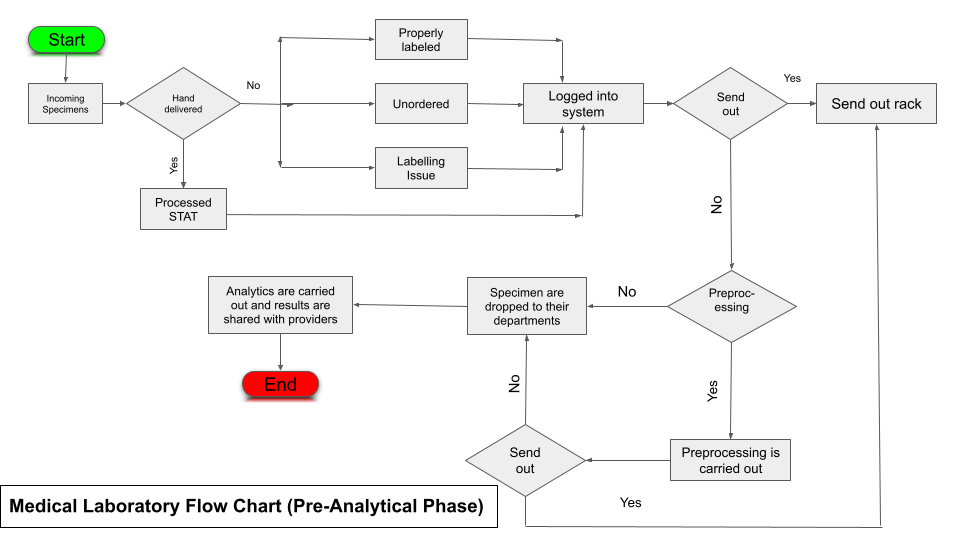

In [1]:
from IPython.display import Image
Image("D:\CUNY\summer 1\Data 604\Flow chart for final project data 604.png")

## Simulation and Iterations:

From the flow chart we already know that specimen could be generated either through nurses or tube delivery system so in order to represent that we have two generator function that generates specimens through nurse and tube delivery system. The Simulation focus on the times for nurse and tube un-attended which intern translates for the specimens un-attended. The number of iterations are discussed in the results and discussion where the simulation is run for a specific time over certain amount to days to get the mean of all the values. Now for Simulatioin let's set up our environment first

In [2]:
# Setting up the Environment
import simpy
import random
import numpy as np
import csv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
random.seed(1992)

In [3]:
def specimen_generator_TS(env, ts_inter, mla, order_issues, labeling_issue, pr_time, send_drop, pre_pro, inhouse_drop, rec_time):
    '''
    This generator function generates nurses that walk down specimens to the lab
    '''
    tube = 0
    
    while True:
        p = processing_generator_TS(env, mla, order_issues, labeling_issue, tube,pr_time, send_drop, pre_pro, inhouse_drop, rec_time)
        env.process(p)
        t = random.expovariate(1.0/ts_inter)
        
        yield env.timeout(t)
        
        tube +=1

In [4]:
def specimen_generator_nurse(env, n_inter, pr_time, send_drop, pre_pro, inhouse_drop, mla):
    '''
    This generator function generates tubes that comes through the tube delivery system
    '''
    
    nurse = 0
    
    while True:
        n = processing_generator_nurse(env, pr_time, send_drop, pre_pro, inhouse_drop, mla, nurse)
        env.process(n)
        tn = random.expovariate(1.0/n_inter)
        yield env.timeout(tn)
        
        nurse +=1

The function `specimen_generator_TS()` generate specimen through tube delivery system and takes multiple arguments such as inter arrival time (`ts_inter`), a resource(`mla`) and other activity parameter such as ordering issues, labelling issues, processing time, drop off time, sendout time, and recieving time. Similarly, the function `specimen_generator_nurse` generates specimen walked in by the nurse and it also take multiple arguments such as inter arrival time (`n_inter`), a resource (`mla`) and other activity parameters.After generating the specimens now we will have to generate the activities or processes that are going to carry out to the specimens so below we have to activity functions for each generator function. 

In [5]:
def processing_generator_TS(env, mla, order_issues, labeling_issue, tube,pr_time, send_drop, pre_pro, inhouse_drop, rec_time):
    '''
    This Function contains all the activities and processes that will carry out on the specimens that are coming through tube delivery system
    '''
    global tube_unattended
    global ordering_issues
    global label_issues
    global order_issue_processing_time
    global label_issue_processing_time
    global no_issue_processing_total_time
    global time_report_ts
    global tube_number ,label_issue_time, tube_drop_time , tube_picked_time ,order_issue_time ,order_issue_fixed_time,recieved_order_time,order_inhouse_drop_time
    
    
    
    tube_number.append(tube)
    time_tube_drop = env.now
    tube_drop_time.append(time_tube_drop)
    #print("Tube ", tube, " dropped at station at ", time_tube_drop, sep = "")
    
    with mla.request() as req:
        yield req
        
        time_tube_picked = env.now        
        tube_picked_time.append(time_tube_picked)        
        #print("Tube ", tube, " picked from station at ", time_tube_picked, sep ="")        
        tube_time_at_station = (time_tube_picked-time_tube_drop)        
        tube_unattended.append(tube_time_at_station)        
        #print("Tube ", tube, " un-attended at station for ", tube_time_at_station, " minutes.", sep="")        
        specimen_issues = random.uniform(0,1)  
        
        if specimen_issues <= .2:        
            
            order_issue = env.now            
            order_issue_time.append(order_issue)            
            #print("Specimens in Tube ", tube," Has Ordering Issues ",sep="")            
            fixing_order_issues = random.expovariate(1.0/order_issues)            
            yield env.timeout(fixing_order_issues)            
            order_issue_fixed = env.now            
            order_issue_fixed_time.append(order_issue_fixed)            
            #print("Ordering issues for Specimens in Tube ", tube, "has been fixed at " ,order_issue_fixed,sep="")                        
            time_for_fixing = (order_issue_fixed - order_issue)            
            #print("It took  ", time_for_fixing, " minutes to fix ordering issues",sep="")            
            ordering_issues.append(time_for_fixing)            
            order_recieving_time = random.expovariate(1.0/ rec_time)            
            yield env.timeout(order_recieving_time)                            
            recieved_order = env.now            
            recieved_order_time.append(recieved_order)            
            sendout_inhouse = random.uniform(0,1)
            
            if sendout_inhouse <.2:
                
                ready_for_drop_send = env.now            
               # print("Specimens dropped in tube " , tube," are ready to be processed for send out at ", ready_for_drop," minutes ", sep="")            
                sampled_sendout_processed = random.expovariate(1.0/send_drop)            
                yield env.timeout(sampled_sendout_processed)            
            else:
                ready_for_drop_in = env.now            
                #print("Specimens dropped in Tube " , tube," are checked for pre-processing at ", ready_for_drop," minutes ", sep="")            
                pre_processing = random.uniform(0,1)            
                if pre_processing <.2:
                
                    ready_for_drop_pre = env.now                
                    #print("Specimens dropped in Tube " , tube," are ready for Preprocessing (spinning/aliqoutting) at ", ready_for_drop, " minutes ", sep ="")                
                    sampled_pre_processed = random.expovariate(1.0/pre_pro)                
                    yield env.timeout(sampled_pre_processed)                
                    after_preprocessed = env.now                
                    #print("Specimens dropped in Tube " , tube," are pre-processed and ready to drop to their respective locations at ",after_preprocessed, sep="")                
                    sampled_inhouse_drop_pre = random.expovariate(1.0/inhouse_drop)                    
                    yield env.timeout(sampled_inhouse_drop_pre)                
                    ts_pre_inhouse_drop_time = env.now                
                    #print("Specimens dropped in Tube " , tube," are dropped to their locations at ",nurse_pre_inhouse_drop_time, sep="")
  
                
                else:
                    ready_for_drop_no_pre = env.now                
                    #print("Specimens dropped in Tube " , tube," are ready to drop to their respective locations at ",ready_for_drop, sep="")                
                    sampled_inhouse_drop = random.expovariate(1.0/inhouse_drop)                    
                    yield env.timeout(sampled_inhouse_drop)                
                    order_inhouse_drop = env.now                    
                    order_inhouse_drop_time.append(order_inhouse_drop)                    
                    total_time_ordering_issue = (order_inhouse_drop - time_tube_drop)                    
                    order_issue_processing_time.append(total_time_ordering_issue)                
                    #print("Specimens dropped in Tube " , tube," are dropped to their locations at ",order_inhouse_drop, sep="")

                    
        elif specimen_issues<=.5 and specimen_issues >=.2:
 
            label_issue = env.now            
            label_issue_time.append(label_issue)                
            #print(" Specimens dropped in Tube ", tube, " has labelling issues", sep="")                
            fixing_labeling_issue = random.expovariate(1.0/labeling_issue)                            
            yield env.timeout(fixing_labeling_issue)            
            label_issue_fixed = env.now                            
            #print("Specimens dropped in Tube ", tube," labeling issue hasbeen fixed at ", label_issue_fixed,sep="")                
            time_for_fixing_label = (label_issue_fixed - label_issue) 
            #print("Specimens dropped in Tube ",tube," took ",time_for_fixing_label, " minutes to fix labels",sep="")                            
            label_issues.append(time_for_fixing_label)            
            label_recieving_time = random.expovariate(1.0/ rec_time)            
            yield env.timeout(label_recieving_time)                            
            recieved_label = env.now      
            
            sendout_inhouse = random.uniform(0,1)
            
            if sendout_inhouse <.2:                
                ready_for_drop_l_send = env.now            
                #print("Specimens dropped in tube " , tube," are ready to be processed for send out at ", ready_for_drop," minutes ", sep="")            
                sampled_sendout_processed = random.expovariate(1.0/send_drop)            
                yield env.timeout(sampled_sendout_processed)
            
            else:
                ready_for_drop_l_in = env.now            
                #print("Specimens dropped in Tube " , tube," are checked for pre-processing at ", ready_for_drop," minutes ", sep="")            
                pre_processing = random.uniform(0,1)
            
                if pre_processing <.2:                
                    ready_for_drop_l_pre = env.now                
                    #print("Specimens dropped in Tube " , tube," are ready for Preprocessing (spinning/aliqoutting) at ", ready_for_drop, " minutes ", sep ="")                
                    sampled_pre_processed = random.expovariate(1.0/pre_pro)                
                    yield env.timeout(sampled_pre_processed)                
                    after_preprocessed = env.now                
                    #print("Specimens dropped in Tube " , tube," are pre-processed and ready to drop to their respective locations at ",after_preprocessed, sep="")                
                    sampled_inhouse_drop_pre = random.expovariate(1.0/inhouse_drop)                    
                    yield env.timeout(sampled_inhouse_drop_pre)                
                    nurse_pre_inhouse_drop_time = env.now 
                    #print("Specimens dropped in Tube " , tube," are dropped to their locations at ",nurse_pre_inhouse_drop_time, sep="")                
                    
                
                else:
                    ready_for_drop_l_no_pre = env.now                
                    #print("Specimens dropped in Tube " , tube," are ready to drop to their respective locations at ",ready_for_drop, sep="")                
                    sampled_inhouse_drop = random.expovariate(1.0/inhouse_drop)                    
                    yield env.timeout(sampled_inhouse_drop)                
                    label_inhouse_drop = env.now                
                    #print("Specimens dropped in Tube " , tube," are dropped to their locations at ",label_inhouse_drop, sep="")                
                    label_issue_total_processing = (label_inhouse_drop -time_tube_drop)                    
                    label_issue_processing_time.append(label_issue_total_processing)                
        else:
            no_issue = env.now                            
            #print("Specimens dropped in Tube ", tube, " has no issue and are ready to recieve ", sep="")       
            sampled_recieving_time = random.expovariate(1.0/ rec_time)            
            yield env.timeout(sampled_recieving_time)                            
            recieved = env.now                            
            #print("Specimens in Tube ", tube, " are processed at ", recieved, sep="")
            
            sendout_inhouse = random.uniform(0,1)            
            if sendout_inhouse <.2:
                
                ready_for_drop = env.now            
                #print("Specimens dropped in tube " , tube," are ready to be processed for send out at ", ready_for_drop," minutes ", sep="")            
                sampled_sendout_processed = random.expovariate(1.0/send_drop)            
                yield env.timeout(sampled_sendout_processed)
            
            else:
                ready_for_drop = env.now            
                #print("Specimens dropped in Tube " , tube," are checked for pre-processing at ", ready_for_drop," minutes ", sep="")            
                pre_processing = random.uniform(0,1)
            
                if pre_processing <.2:                
                    ready_for_drop = env.now                
                    #print("Specimens dropped in Tube " , tube," are ready for Preprocessing (spinning/aliqoutting) at ", ready_for_drop, " minutes ", sep ="")                
                    sampled_pre_processed = random.expovariate(1.0/pre_pro)                
                    yield env.timeout(sampled_pre_processed)                
                    after_preprocessed = env.now                
                    #print("Specimens dropped in Tube " , tube," are pre-processed and ready to drop to their respective locations at ",after_preprocessed, sep="")                
                    sampled_inhouse_drop_pre = random.expovariate(1.0/inhouse_drop)                    
                    yield env.timeout(sampled_inhouse_drop_pre)                
                    nurse_pre_inhouse_drop_time = env.now 
                    #print("Specimens dropped in Tube " , tube," are dropped to their locations at ",nurse_pre_inhouse_drop_time, sep="")
                

                else:
                    ready_for_drop = env.now                
                    #print("Specimens dropped in Tube " , tube," are ready to drop to their respective locations at ",ready_for_drop, sep="")                
                    sampled_inhouse_drop = random.expovariate(1.0/inhouse_drop)                
                    yield env.timeout(sampled_inhouse_drop)                    
                    no_issue_inhouse_drop = env.now                    
                    no_issue_processing_time = (no_issue_inhouse_drop - time_tube_drop)                    
                    no_issue_processing_total_time.append(no_issue_processing_time)                
                    #print("Specimens dropped in Tube " , tube," are dropped to their locations at ",no_issue_inhouse_drop, sep="")
    
    

In [6]:
def processing_generator_nurse(env, pr_time, send_drop, pre_pro, inhouse_drop, mla, nurse):
    
    '''
    This Function contains all the activities and processes that will carry out on the specimens that are walked down by nurses
    '''
    global nurse_waiting_time
    
    nurse_walkin= env.now    
    #print("Nurse ", nurse, " walked down specimen to lab at ", nurse_walkin, sep = "")    
    with mla.request() as req:
        yield req        
        time_attended_nurse = env.now        
        #print("Attended Nurse ", nurse, " and got specimen of her hand at ", time_attended_nurse, sep ="")        
        nurse_waited = (time_attended_nurse-nurse_walkin)        
        nurse_waiting_time.append(nurse_waited)        
        #print("Nurse ", nurse, " waited un-attended at central for ", nurse_waited, " minutes ", sep ="")        
        sampled_recieving_time = random.expovariate(1.0/pr_time)        
        yield env.timeout(sampled_recieving_time)       
        
        sendout_inhouse = random.uniform(0,1)        
        if sendout_inhouse <.2:            
            ready_for_drop = env.now            
            #print("Specimens walked down by Nurse " , nurse," are ready to be processed for send out at ", ready_for_drop," minutes ", sep="")            
            sampled_sendout_processed = random.expovariate(1.0/send_drop)            
            yield env.timeout(sampled_sendout_processed)
            
        else:
            ready_for_drop = env.now            
            #print("Specimens walked down by Nurse " , nurse," are checked for pre-processing at ", ready_for_drop," minutes ", sep="")            
            pre_processing = random.uniform(0,1)            
            if pre_processing <.2:                
                ready_for_drop = env.now                
                #print("Specimens walked down by Nurse " , nurse," are ready for Preprocessing (spinning/aliqoutting) at ", ready_for_drop, " minutes ", sep ="")                
                sampled_pre_processed = random.expovariate(1.0/pre_pro)                
                yield env.timeout(sampled_pre_processed)                
                after_preprocessed = env.now                
                #print("Specimens walked down by Nurse " , nurse," are pre-processed and ready to drop to their respective locations at ",after_preprocessed, sep="")                
                sampled_inhouse_drop_pre = random.expovariate(1.0/inhouse_drop)                
                yield env.timeout(sampled_inhouse_drop_pre)                
                nurse_pre_inhouse_drop_time = env.now 
                #print("Specimens walked down by Nurse " , nurse," are dropped to their locations at ",nurse_pre_inhouse_drop_time, sep="")                
                
                
            else:
                ready_for_drop = env.now                
                #print("Specimens walked down by Nurse " , nurse," are ready to drop to their respective locations at ",ready_for_drop, sep="")                
                sampled_inhouse_drop = random.expovariate(1.0/inhouse_drop)                
                yield env.timeout(sampled_inhouse_drop)                
                nurse_inhouse_drop = env.now                
                #print("Specimens walked down by Nurse " , nurse," are dropped to their locations at ",nurse_inhouse_drop, sep="")
     
        

##  Verification and Validation:

### Verification
Verification was carried out by collecting the the time report after certain processes in the activity generator and compared it to the average times taken by each process. For instance, the simulation was model to have less than 20% of tube (specimens) with ordering issue so compared the total number of tube recieved to the tubes that has specimens with ordering issues and it turns out to be less than 20% which verifies that our model is working the way it was intended to be. Below is the code that shows the verification of the model.



In [7]:
#Data Collection for verification

tube_number =[]
tube_drop_time = []
tube_picked_time = [] 
order_issue_time = [] 
order_issue_fixed_time = []
recieved_order_time = []
order_inhouse_drop_time = []
label_issue_time = []

nurse_waiting_time =[]
tube_unattended = []
ordering_issues = []
label_issues = []
order_issue_processing_time = []
label_issue_processing_time = []
no_issue_processing_total_time =[]


In [8]:
#Setting up simpy environment to collect data and run simulation
env = simpy.Environment()
mla = simpy.Resource(env, capacity =4)
ts_inter = 2
rec_time = 2
n_inter = 10
pr_time = 2
send_drop = 2
pre_pro = 2
inhouse_drop = 3
order_issues = 5
labeling_issue = 4
env.process(specimen_generator_TS(env, ts_inter, mla, order_issues, labeling_issue, pr_time, send_drop, pre_pro, inhouse_drop, rec_time))
env.process(specimen_generator_nurse(env, n_inter, pr_time, send_drop, pre_pro, inhouse_drop, mla))
env.run(until = 120)


Now our simulation is already ran and we have collected the data at different times with in the model. Now in order to verify our model we can see the number tube dropped during the whole 120 min simulation and then we also check the number of tubes that has order issues and if its less that 20% it means that the model is working the way it was suppose to be. So lets create small data frames for each and count the number

In [9]:
reports = pd.DataFrame({"Tube Number": tube_number,
                        "Tube Drop Time":tube_drop_time })
Number_of_total_tubes  =reports['Tube Number'].count()

In [10]:
order_issue_report = pd.DataFrame({"Order Issue Time":order_issue_time })
Number_of_order_issue = order_issue_report['Order Issue Time'].count()

In [11]:
Percent_order_issue =(Number_of_order_issue/Number_of_total_tubes)*100
Percent_order_issue = round(Percent_order_issue, 2)
print(Percent_order_issue)

18.37


As we can see that the number of tubes that contains the specimen with order issues are at almost 18% which is less than 20% as we intended to achieve with our model. We can also the number of tube against time graphically

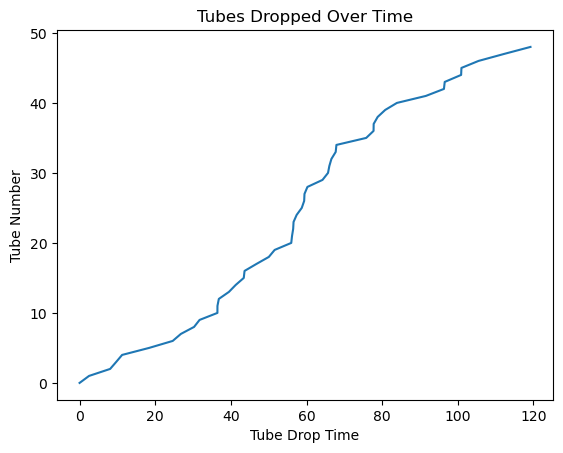

In [12]:
sns.lineplot(reports, x ="Tube Drop Time", y="Tube Number" )
plt.title("Tubes Dropped Over Time")
plt.show()

### Validation:

Now Validation was relatively hard to carry out since we have to telly this simulation to an actual process and in order to achieve that we have to have data from the real world system. The good news is that I personally work in this medical laboratory and I can assure that the process times that taken in the simulation are very close to the actual processing times but sometimes assurance is not enough so I did make my colleagues to gather some data for a week. According to the gather data we were suppose to recieve 219 tubes on average every 480 mins which comes up to be 54-55 tubes per 120 mins which falls aligned with our simulation models. Similarly, according to the same data average processing time for specimen or tubes with no issues was approximately 13 mins and according to the simulation it was almost 15 mins as shown below.

In [13]:
np.mean(no_issue_processing_total_time)

15.684970031279436

The reason why couldn't import the data set into notebook was that the data sets were no where near to be called as clean and workable since everyone had their way of dealing with it. Eventually, I had to carry out a lot manual calculations to get the averages and sums. Following are the links for some of the sheet that contains the data

https://docs.google.com/spreadsheets/d/bc1qugrtknpjz52vc4m559q7zumkc4268kp7skrsee-oR4/edit#gid=0
https://docs.google.com/spreadsheets/d/1FNbFHc0aZMUOjTuX-ELNymX7QC5EZf_nfdp_wpK5Bhk/edit#gid=0
https://docs.google.com/spreadsheets/d/bc1qugrtknpjz52vc4m559q7zumkc4268kp7skrsee/edit#gid=0
https://docs.google.com/spreadsheets/d/1sQKlUp3AFzvycHN0j1K7UbA3o8FPI8cjIr2L7YdebsQ/edit#gid=0

## Results and Discussions

This whole simulation was designed to find out if an extra resource will help the laboratory perform better or no and how much does pre-existing issues like order and label can effect the overall processing time. The simulation is designed for a night shift where sometimes we have four assistant and sometimes we have three and higher management is always in favor of having three assistants. To end this conversation once and for all this simualtion was designed. Before moving ahead the simulation is set up in a way that the medical lab assistant (MLA) will complete one task and then move on to the other which is a common practice while dealing with huge volumes of specimen to avoid any mistakes that can endanger patient's life. So for that particular reason during simulation no special previleges are given to STAT specimen when all the resources (MLA) are busy performing one task.

Now to find out if an extra assistant would help the lab perform better the simulation has been run twice a 100 times for 3 and 4 resources and the results are compared. The code below runs the simulation for 100 days and each day it is running for 2 hours or 120 min. The reason why I have picked 120 mins is that all 4 or 3 MLA will be present during that time. After 120 mins of the shift each MLA go their respective break. And the reason for running the simulation for 100 days was reduce variance as much as possible and to attain a meaningful value for processes in question.

### Checking the response of model with different resources:

In [14]:
with open('lab4_results.csv', 'w') as f:
    writer = csv.writer(f, delimiter=",")
    writer.writerow(["Run","Mean Nurse Wait", "Mean Tube unattended","Mean Ordering Issue Time","Mean Labeling Issue Time", "Ordering Issue Processing Time", "Labeling Issue Processing Time", "No Issue Processing Time", "MLA"])
simulation_runs=100
for run in range(simulation_runs):
    env = simpy.Environment()
    mla = simpy.Resource(env, capacity =4)
    ts_inter = 2
    rec_time = 3
    n_inter = 10
    pr_time = 2
    send_drop = 2
    pre_pro = 2
    inhouse_drop = 3
    order_issues = 3
    labeling_issue = 2
    
    nurse_waiting_time =[]
    tube_unattended = []
    ordering_issues = []
    label_issues = []
    order_issue_processing_time = []
    label_issue_processing_time = []
    no_issue_processing_total_time =[]
    
    env.process(specimen_generator_TS(env, ts_inter, mla, order_issues, labeling_issue, pr_time, send_drop, pre_pro, inhouse_drop, rec_time))
    env.process(specimen_generator_nurse(env, n_inter, pr_time, send_drop, pre_pro, inhouse_drop, mla))
    env.run(until = 120)
    
    mean_nurse_waited_time = np.mean(nurse_waiting_time)
    mean_tube_time_at_station = np.mean(tube_unattended)
    mean_order_fixing_time = np.mean(ordering_issues)
    mean_label_fixing_time = np.mean(label_issues)
    mean_order_issue_processing_time = np.mean(order_issue_processing_time)
    mean_label_issue_processing_time = np.mean(label_issue_processing_time)
    mean_no_issue_processing_total_time = np.mean(no_issue_processing_total_time)
    
    
    mla = 4
    
    list_to_write = [run,mean_nurse_waited_time,mean_tube_time_at_station,mean_order_fixing_time,mean_label_fixing_time, mean_order_issue_processing_time, mean_label_issue_processing_time,mean_no_issue_processing_total_time, mla ]
    
    with open('lab4_results.csv','a') as f:
        writer = csv.writer(f, delimiter = ",")
        writer.writerow(list_to_write)
results4 = pd.read_csv("lab4_results.csv")



Similarly, lets run the simulation for same amount of time having 3 MLAs.

In [15]:
with open('lab3_results.csv', 'w') as f:
    writer = csv.writer(f, delimiter=",")
    writer.writerow(["Run","Mean Nurse Wait", "Mean Tube unattended","Mean Ordering Issue Time","Mean Labeling Issue Time", "Ordering Issue Processing Time", "Labeling Issue Processing Time", "No Issue Processing Time", "MLA"])
simulation_runs=100
for run in range(simulation_runs):
    env = simpy.Environment()
    mla = simpy.Resource(env, capacity =3)
    ts_inter = 2
    rec_time = 3
    n_inter = 10
    pr_time = 2
    send_drop = 2
    pre_pro = 2
    inhouse_drop = 3
    order_issues = 3
    labeling_issue = 2
    
    nurse_waiting_time =[]
    tube_unattended = []
    ordering_issues = []
    label_issues = []
    order_issue_processing_time = []
    label_issue_processing_time = []
    no_issue_processing_total_time =[]
    
    env.process(specimen_generator_TS(env, ts_inter, mla, order_issues, labeling_issue, pr_time, send_drop, pre_pro, inhouse_drop, rec_time))
    env.process(specimen_generator_nurse(env, n_inter, pr_time, send_drop, pre_pro, inhouse_drop, mla))
    env.run(until = 120)
    
    mean_nurse_waited_time = np.mean(nurse_waiting_time)
    mean_tube_time_at_station = np.mean(tube_unattended)
    mean_order_fixing_time = np.mean(ordering_issues)
    mean_label_fixing_time = np.mean(label_issues)
    mean_order_issue_processing_time = np.mean(order_issue_processing_time)
    mean_label_issue_processing_time = np.mean(label_issue_processing_time)
    mean_no_issue_processing_total_time = np.mean(no_issue_processing_total_time)
    
    
    mla = 3
    
    list_to_write = [run,mean_nurse_waited_time,mean_tube_time_at_station,mean_order_fixing_time,mean_label_fixing_time, mean_order_issue_processing_time, mean_label_issue_processing_time,mean_no_issue_processing_total_time, mla ]
    
    with open('lab3_results.csv','a') as f:
        writer = csv.writer(f, delimiter = ",")
        writer.writerow(list_to_write)
results3 = pd.read_csv("lab3_results.csv")



C:\Users\umer5\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\umer5\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Now we save the results in one data frame and analyze our data:

In [16]:
df_final = pd.concat([results4,results3])

In [17]:
df_final.head()

,Run,Mean Nurse Wait,Mean Tube unattended,Mean Ordering Issue Time,Mean Labeling Issue Time,Ordering Issue Processing Time,Labeling Issue Processing Time,No Issue Processing Time,MLA
0,0,2.410269,1.781087,2.559688,0.974278,8.130252,9.561038,6.606097,4
1,1,7.253971,6.268031,4.285876,1.491703,17.224389,12.601584,11.515562,4
2,2,8.116764,7.372957,2.256269,1.472074,15.780222,13.982643,16.250600,4
3,3,15.501372,11.883361,3.555141,2.109682,20.168150,17.507576,17.338087,4
4,4,7.489782,7.219354,2.005426,2.593283,10.808262,11.060838,15.056677,4


Now our data frame is ready so let;s check out the amount of time nurse waited unattended in the lab since all the MLAs were busy in performing different tasks and lets compare 3 MLAs to 4 MLAs

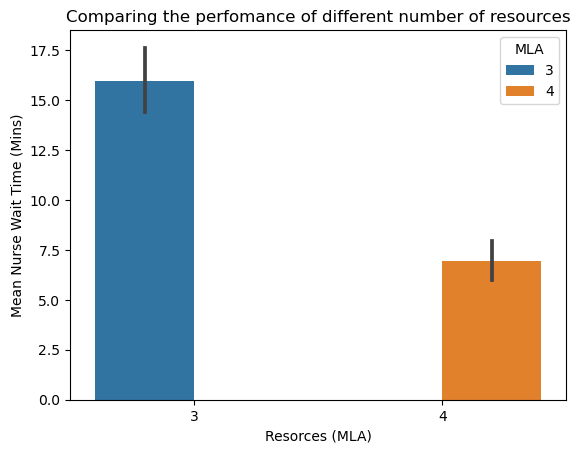

In [18]:
sns.barplot(data = df_final, x = "MLA", y = "Mean Nurse Wait", hue = "MLA")
plt.title("Comparing the perfomance of different number of resources")
plt.xlabel("Resorces (MLA)")
plt.ylabel("Mean Nurse Wait Time (Mins)")
plt.show()

As we can see that with the difference in times is almsot double which clearly favors to have 4 MLAs to improve the performance of the lab. Similarly for tube that remained un-attended at the station was relatively higher that mean nurse wait time since the specimen brought by nurse were processed quicker.

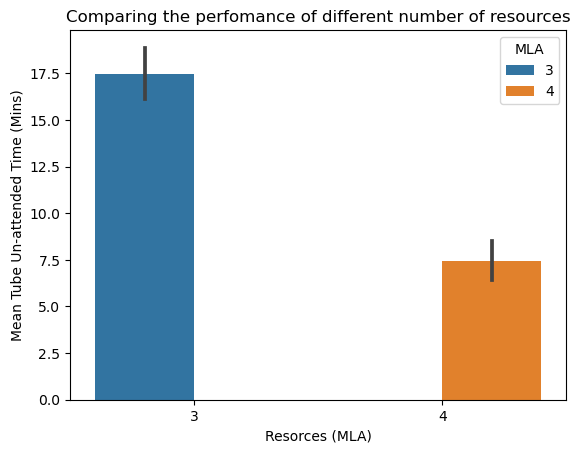

In [19]:
sns.barplot(data = df_final, x = "MLA", y = "Mean Tube unattended", hue = "MLA")
plt.title("Comparing the perfomance of different number of resources")
plt.xlabel("Resorces (MLA)")
plt.ylabel("Mean Tube Un-attended Time (Mins)")
plt.show()

We can clearly see that with 4 resources the tube stays un-attended for around 7.5 mins in the station which is very normal and acceptable since there is a huge volume of tubes coming in. The problem arises when the higher management reduces the number of resources (MLAs) to 3 which drastically increases the tube un-attended time from 7.5 mins to 17.5 mins as shown by the graph above. Now bearing the fact in mind that the medical lab in case of emergency situation can encounter specimens from stroke and rapid response patient through the same tube delivery system and in a situation where tube stays 17.5 mins unattended could really endanger patients life. 

### How much does pre-existing issue affect the overall process time:

The second question or problem that we were trying to address was that, how much does issues like order and label issue affect the overall time. Now in order to find that out we will try to compare the overall processing time, starting from the instance where tube drop to the point where specimens reaches to their respective departments (sink), for tube that has specimen with non issue to specimen that has issues.

In [20]:
round(np.mean(no_issue_processing_total_time),2)

24.39

In [21]:
round(np.mean(order_issue_processing_time),2)

26.22

In [22]:
round(np.mean(order_issue_processing_time),2)

26.22

The above processing times are for when three resources and working not four that is why it is higher than previous one but our idea is to compare the time difference between specimens that has issue vs specimen with no issues. We can see that there is on average 2 mins difference between processing time of specimens with and without issues which is not humungous but if it could be shoved off that would be very welcomed.

We can also check out the distribution of each variable to see the frequency of different time taken by specimen

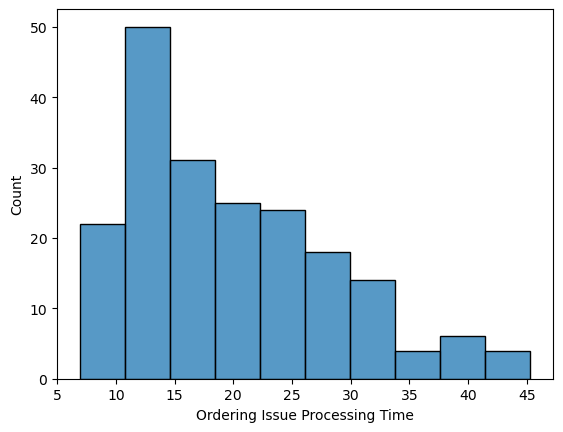

In [23]:
sns.histplot(df_final['Ordering Issue Processing Time'])
plt.show()

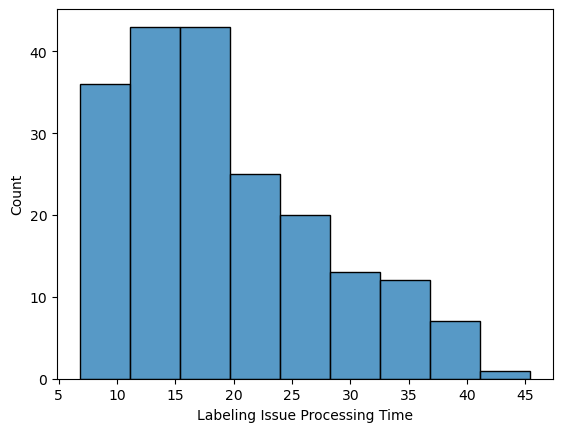

In [24]:
sns.histplot(df_final['Labeling Issue Processing Time'])
plt.show()

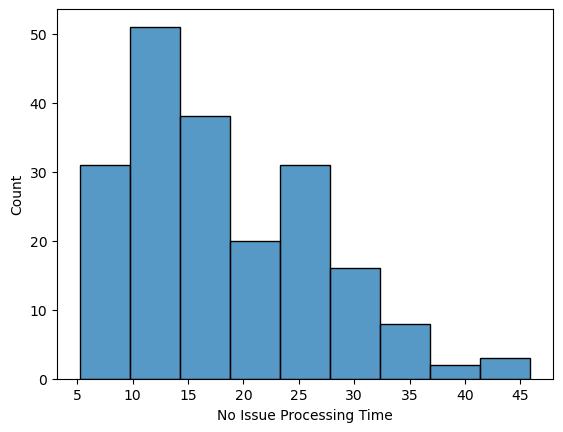

In [25]:
sns.histplot(df_final['No Issue Processing Time'])
plt.show()

All three processing time follow pretty much similar distribution with some of the specimen taking up to 45 mins since no resource was avialable and the code has been set to not give anyone any special previleges to avoid or minimize mistakes.

## Conclusion:

The simulation was designed to find out if the resources available i.e. Medical lab assistant (MLA), to perform pre analytical tasks to specimen coming through tube delivery system or walked down by nurse. The simulation was model to run for 100 days and each day was 120 mins. The simulation was ran twice for number of resources i.e. 3 and 4, and the results were stored in the .csv file. Upon the comparison it was found that if the lab works with only 3 MLAs the processing time is more than twice as compare to having 4 MLAs, which could really affect the performance and turn around time for test. Similarly, emergency situations can be handled more efficiently with 4 MLAs. Another question that needed to be addressed was to find the processing time of specimens with issues that came through tube delivery system and it was found the specimen with issues took 2 minutes over the normal processing time on average and we can speed up the process if the floor send properly label specimens to the lab.

## Limitations:

The simulation model does have some limitations. Here is a list of few

* No STAT situation was encounter
* Due to lack of availability of data exponentially distributed data was used with known averages
* The send out after prepocessing was not included in the model since the percentage of sendout after pre-processing was very low
* Tubes and nurses were used as an alternative for specimens since each tube or nurse comes down with different number of specimen.

## Presentation with graphs:

https://docs.google.com/presentation/d/1Th5U3nlwJHqwBWs63cDdSAcWYx1aU-Yu_IaNiO0HTA4/edit#slide=id.p